In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.brain as fob
from tqdm.notebook import tqdm, tnrange
from PIL import Image
import matplotlib.pyplot as plt
import torchsummary
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os

In [2]:
# Set random seed for reproducibility
# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0)

### Încăracarea setului de date
Folosim LFWfunneled ca set de date, având o aliniere mai bună a fețelor.

In [3]:
lfw_dataset = foz.load_zoo_dataset(
    "lfw",
    split="train",
    shuffle=True,
    seed=0
)
# load data from local
# lfw_dataset = fo.Dataset.from_dir(
#     dataset_dir='/home/ichitu/fiftyone/lfw/lfw_funneled',
#     dataset_type=fo.types.dataset_types.ImageClassificationDirectoryTree,
#     name='lfw_funneled',
#     overwrite=True,
    
# )




Split 'train' already downloaded


Loading existing dataset 'lfw-train'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [4]:
DIM = 224

Crearea unui set de date custom pentru a avea acces prin index la imagini, dar și la etichete pentru o identificare facilă a persoanelor

In [5]:
class LFWDataset:
    def __init__(self, dataset, dim=DIM):
        self.dataset = dataset
        self.filepaths = list(dataset.values("filepath"))
        self.dim = dim
    
    def __len__(self):
        return len(self.filepaths)
    
    def preprocess(self, image, dim):
        image = image.resize((dim, dim))
        return image
    
    def image_path(self, idx):
        return self.filepaths[idx]
    
    def __getitem__(self, idx):
        impath = self.filepaths[idx]
        sample = self.dataset[impath]
        image = Image.open(impath).convert("RGB")
        image = self.preprocess(image, self.dim)
        image = np.array(image)
        label = sample["ground_truth"]["label"]
        return image, label
    
full_dataset = LFWDataset(lfw_dataset, dim=DIM)
print(full_dataset.image_path(7))

/home/ichitu/fiftyone/lfw/train/Sharon_Stone/Sharon_Stone_0005.jpg


### Alegerea perechilor
Conform articolului http://www.whdeng.cn/FGLFW/FGLFW.html alegerea aleatorie a imaginilor duce la o acuratețe mare falsă, imaginile negative fiind cu mult diferite de ancore. Din această cauză folosim un fișier text pentru selectarea perechilor, care la fiecare 600 de linii are 300 de perechi matched, apoi 300 mismatched, alternând între ele de 10 ori. Astfel rezultă 10 seturi cu câte 1200 imagini fiecare

In [6]:
def parse_fglfw_pairs(file_path, dataset_path):
    with open(file_path, "r", encoding="utf-8") as f:
        lines = [line.strip() for line in f.readlines()]

    sets = []
    idx = 0
    # Each set has 600 lines for matched (300 pairs) and 600 lines for mismatched (300 pairs)
    for _ in range(10):
        matched = []
        mismatched = []
        # Read 300 matched pairs (2 lines each)
        for i in range(300):
            # add dataset path to image paths
            matched.append((os.path.join(dataset_path, lines[idx + 2*i]), os.path.join(dataset_path, lines[idx + 2*i + 1])))
        idx += 600
        # Read 300 mismatched pairs (2 lines each)
        for i in range(300):
            # add dataset path to image paths
            mismatched.append((os.path.join(dataset_path, lines[idx + 2*i]), os.path.join(dataset_path, lines[idx + 2*i + 1])))
        idx += 600
        sets.append({"matched": matched, "mismatched": mismatched})

    return sets

In [7]:
file_path = "/home/ichitu/fiftyone/lfw/lfw_funneled/pair_FGLFW.txt"
pairs = parse_fglfw_pairs(file_path, "/home/ichitu/fiftyone/lfw/lfw_funneled")
print("Parsed", len(pairs), "sets.")
print("Each set has:", len(pairs[0]["matched"]), "matched pairs and", len(pairs[0]["mismatched"]), "mismatched pairs.")

Parsed 10 sets.
Each set has: 300 matched pairs and 300 mismatched pairs.


Generarea de batch-uri pe baza perechilor formate mai sus

In [8]:
def batch_generator(dataset, pairs, batch_size, dim=DIM, dataset_path="/home/ichitu/fiftyone/lfw/lfw_funneled"):
    dataset_size = len(dataset)
    if dataset_size < batch_size:
        raise ValueError("Dataset size is smaller than the batch size. \
                         Cannot generate batches.")
    
    anchors_positives = [np.zeros((batch_size, dim, dim, 3), dtype=np.float32), 
               [""] * batch_size]
    positives = [np.zeros((batch_size, dim, dim, 3), dtype=np.float32), 
                 [""] * batch_size]
    anchors_negatives = [np.zeros((batch_size, dim, dim, 3), dtype=np.float32), 
                 [""] * batch_size]
    negatives = [np.zeros((batch_size, dim, dim, 3), dtype=np.float32), 
                 [""] * batch_size]
    while True:
        for i in range(batch_size):
            # Select a random set
            set_ = random.choice(pairs)
            # Select a random matched pair
            matched_pair = random.choice(set_["matched"])
            # Select a random mismatched pair
            mismatched_pair = random.choice(set_["mismatched"])
            # Load the images
            anchor_positive = Image.open(matched_pair[0]).convert("RGB")
            positive = Image.open(matched_pair[1]).convert("RGB")
            anchors_negative = Image.open(mismatched_pair[0]).convert("RGB")
            negative = Image.open(mismatched_pair[1]).convert("RGB")
            # Preprocess the images
            anchor_positive = anchor_positive.resize((dim, dim))
            positive = positive.resize((dim, dim))
            anchors_negative = anchors_negative.resize((dim, dim))
            negative = negative.resize((dim, dim))
            # Convert to numpy arrays
            anchor_positive = np.array(anchor_positive)
            positive = np.array(positive)
            anchors_negative = np.array(anchors_negative)
            negative = np.array(negative)
            # Add to the batch
            anchors_positives[0][i] = anchor_positive
            anchors_positives[1][i] = matched_pair[0]
            positives[0][i] = positive
            positives[1][i] = matched_pair[1]
            anchors_positives[0][i] = anchor_positive / 255.
            anchors_positives[1][i] = matched_pair[0].replace(dataset_path + "/","").split("/")[0]
            positives[0][i] = positive / 255.
            positives[1][i] = matched_pair[1].replace(dataset_path + "/","").split("/")[0]
            anchors_negatives[0][i] = anchors_negative / 255.
            anchors_negatives[1][i] = mismatched_pair[0].replace(dataset_path + "/","").split("/")[0]
            negatives[0][i] = negative / 255.
            negatives[1][i] = mismatched_pair[1].replace(dataset_path + "/","").split("/")[0]
        yield [anchors_positives, positives, anchors_negatives, negatives]
        


Generarea în mod aleator a batch-urilor

In [9]:
def batch_generator3(dataset, pairs, batch_size, dim=DIM, dataset_path="/home/ichitu/fiftyone/lfw/lfw_funneled"):
    dataset_size = len(dataset)
    if dataset_size < batch_size:
        raise ValueError("Dataset size is smaller than the batch size. \
                         Cannot generate batches.")
    
    anchors_positives = [np.zeros((batch_size, dim, dim, 3), dtype=np.float32), 
               [""] * batch_size]
    positives = [np.zeros((batch_size, dim, dim, 3), dtype=np.float32), 
                 [""] * batch_size]
    anchors_negatives = [np.zeros((batch_size, dim, dim, 3), dtype=np.float32), 
                 [""] * batch_size]
    negatives = [np.zeros((batch_size, dim, dim, 3), dtype=np.float32), 
                 [""] * batch_size]
    while True:
        for i in range(batch_size):
            # Select a random set
            set_ = random.choice(pairs)
            # Select a random matched pair
            matched_pair = random.choice(set_["matched"])
            # Select a mismatched pair which has the anchor from the matched pair
            mismatched_pairs_list = [pair for pair in set_["mismatched"] if pair[0] == matched_pair[0]]
            # print(mismatched_pairs_list)
            if len(mismatched_pairs_list) == 0:
                mismatched_pair = random.choice(set_["mismatched"])
            else:
                mismatched_pair = random.choice(mismatched_pairs_list)
            # Load the images
            anchor_positive = Image.open(matched_pair[0]).convert("RGB")
            positive = Image.open(matched_pair[1]).convert("RGB")
            anchors_negative = Image.open(mismatched_pair[0]).convert("RGB")
            negative = Image.open(mismatched_pair[1]).convert("RGB")
            # Preprocess the images
            anchor_positive = anchor_positive.resize((dim, dim))
            positive = positive.resize((dim, dim))
            anchors_negative = anchors_negative.resize((dim, dim))
            negative = negative.resize((dim, dim))
            # Convert to numpy arrays
            anchor_positive = np.array(anchor_positive)
            positive = np.array(positive)
            anchors_negative = np.array(anchors_negative)
            negative = np.array(negative)
            # Add to the batch
            anchors_positives[0][i] = anchor_positive
            anchors_positives[1][i] = matched_pair[0]
            positives[0][i] = positive
            positives[1][i] = matched_pair[1]
            anchors_positives[0][i] = anchor_positive / 255.
            anchors_positives[1][i] = matched_pair[0].replace(dataset_path + "/","").split("/")[0]
            positives[0][i] = positive / 255.
            positives[1][i] = matched_pair[1].replace(dataset_path + "/","").split("/")[0]
            anchors_negatives[0][i] = anchors_negative / 255.
            anchors_negatives[1][i] = mismatched_pair[0].replace(dataset_path + "/","").split("/")[0]
            negatives[0][i] = negative / 255.
            negatives[1][i] = mismatched_pair[1].replace(dataset_path + "/","").split("/")[0]
        yield [anchors_positives, positives, anchors_negatives, negatives]
        


Testez generatorul

In [10]:
BS = 1
generator = batch_generator3(full_dataset, pairs, BS)

['Hilmi_Ozkok']
['Hilmi_Ozkok']
['Franz_Beckenbauer']
['Lawrence_MacAulay']


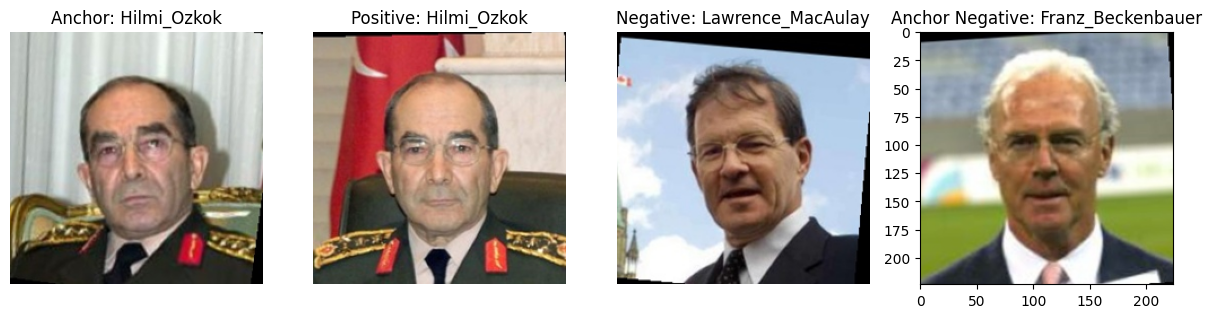

In [11]:
# Get a batch of data
batch = next(generator)
anchor = batch[0]
positive = batch[1]
anchor_negative = batch[2]
negative = batch[3]
print(anchor[1])
print(positive[1])
print(anchor_negative[1])
print(negative[1])
for i in range(BS):
    fig, ax = plt.subplots(1, 4, figsize=(15, 15))
    ax[0].imshow(anchor[0][i])
    ax[0].set_title("Anchor:" + " " + anchor[1][i])
    ax[0].axis("off")
    ax[1].imshow(positive[0][i])
    ax[1].set_title("Positive:" + " " + positive[1][i])
    ax[1].axis("off")
    ax[2].imshow(negative[0][i])
    ax[2].set_title("Negative:" + " " + negative[1][i])
    ax[2].axis("off")
    ax[3].imshow(anchor_negative[0][i])
    ax[3].set_title("Anchor Negative:" + " " + anchor_negative[1][i])
    plt.show()

### Modelele


##### Model după Zeiler-Fergus
Am încercat implementarea lui, dar nu am reușit, neclarități în cum ar trebui implementat conform https://arxiv.org/pdf/1503.03832

In [12]:
class FaceRecZF(nn.Module):
    def __init__(self, input_shape = (3, 220, 220)):
        super(FaceRecZF, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.rnorm1 = nn.LocalResponseNorm(size=1)
        self.conv2a = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, stride=1, padding=1)
        self.rnorm2 = nn.LocalResponseNorm(size=1)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv3a = nn.Conv2d(in_channels=192, out_channels=192, kernel_size=1, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv4a = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=1, stride=1, padding=0)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv5a = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, stride=1, padding=0)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv6a = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, stride=1, padding=0)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.concat = nn.Flatten()
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc7132 = nn.Linear(128, 128)

    def L2Norm(self, x):
        return F.normalize(x, p=2, dim=1)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.rnorm1(x)
        x = F.relu(self.conv2a(x))
        x = F.relu(self.conv2(x))
        x = self.rnorm2(x)
        x = self.pool2(x)
        x = F.relu(self.conv3a(x))
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4a(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5a(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6a(x))
        x = F.relu(self.conv6(x))
        x = self.pool4(x)
        # x = self.concat(x)
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc7132(x)
        return x
    

In [13]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = FaceRecZF().to(device)
# torchsummary.summary(model, (3, 220, 220))

### Model după GoogleLeNet
Tot conform articolului de mai sus, dar pentru blocurile de inception am folosit publicația https://arxiv.org/pdf/1409.4842

<img src="/home/ichitu/py-files/Resources/Captură de ecran 2025-01-20 112241.png">

In [14]:
class FaceRecInception(nn.Module):
    def __init__(self, input_shape=(3, 220, 220)):
        super(FaceRecInception, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.rnorm1 = nn.LocalResponseNorm(size=1)
        
        # Inception Module 1
        def inception_block1(in_channels, out_channels):
            conv3x3_reduce = nn.Conv2d(in_channels, out_channels[0], kernel_size=1)
            conv3x3 = nn.Conv2d(out_channels[0], out_channels[1], kernel_size=3, padding=1)
            return nn.Sequential(
                conv3x3_reduce,
                nn.ReLU(),
                conv3x3,
                nn.ReLU()
            )    
        self.inception1 = inception_block1(64, [64, 192])

        self.rnorm2 = nn.LocalResponseNorm(size=1)
        self.max_pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Inception Modules 1x1, 3x3, 5x5, and Pooling
        def inception_block1x1(in_channels, out_channels):
            conv1x1 = nn.Conv2d(in_channels, out_channels[0], kernel_size=1)
            return nn.Sequential(
                conv1x1,
                nn.ReLU()
            )
        def inception_block3x3(in_channels, out_channels, stride=1):
            conv3x3_reduce = nn.Conv2d(in_channels, out_channels[0], kernel_size=1)
            conv3x3 = nn.Conv2d(out_channels[0], out_channels[1], kernel_size=3, padding=1, stride=stride)
            return nn.Sequential(
                conv3x3_reduce,
                nn.ReLU(),
                conv3x3,
                nn.ReLU()
            )
        def inception_block5x5(in_channels, out_channels, stride=1):
            conv5x5_reduce = nn.Conv2d(in_channels, out_channels[0], kernel_size=1)
            conv5x5 = nn.Conv2d(out_channels[0], out_channels[1], kernel_size=5, padding=2, stride=stride)
            return nn.Sequential(
                conv5x5_reduce,
                nn.ReLU(),
                conv5x5,
                nn.ReLU()
            )
        
        class L2Pooling(nn.Module):
            def __init__(self):
                super(L2Pooling, self).__init__()
            def forward(self, x):
                return torch.sqrt(F.avg_pool2d(x**2, kernel_size=3, stride=1, padding=1))

        def pool_proj(in_channels, out_channels, max_pool=True):
            if max_pool:
                return nn.Sequential(
                    nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                    nn.Conv2d(in_channels, out_channels, kernel_size=1),
                    nn.ReLU()
                   )
            else:
                return nn.Sequential(
                    L2Pooling(),
                    nn.Conv2d(in_channels, out_channels, kernel_size=1),
                    nn.ReLU()
                )
        
        # Inception Module 3a
        self.inception3a1x1 = inception_block1x1(192, [64])
        self.inception3a3x3 = inception_block3x3(192, [96, 128])
        self.inception3a5x5 = inception_block5x5(192, [16, 32])
        self.inception3apool = pool_proj(192, 32, max_pool=True)

        # Inception Module 3b
        self.inception3b1x1 = inception_block1x1(256, [64])
        self.inception3b3x3 = inception_block3x3(256, [96, 128])
        self.inception3b5x5 = inception_block5x5(256, [32, 64])
        self.inception3bpool = pool_proj(256, 64, max_pool=False)

        # Inception Module 3c
        self.inception3c3x3 = inception_block3x3(320, [128, 256], stride=2)
        self.inception3c5x5 = inception_block5x5(320, [32, 64], stride=2)
        self.inception3cpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Inception Module 4a
        self.inception4a1x1 = inception_block1x1(640, [256])
        self.inception4a3x3 = inception_block3x3(640, [96, 192])
        self.inception4a5x5 = inception_block5x5(640, [32, 64])
        self.inception4apool = pool_proj(640, 128, max_pool=False)

        # Inception Module 4b
        self.inception4b1x1 = inception_block1x1(640, [DIM])
        self.inception4b3x3 = inception_block3x3(640, [112, DIM])
        self.inception4b5x5 = inception_block5x5(640, [32, 64])
        self.inception4bpool = pool_proj(640, 128, max_pool=False)

        # Inception Module 4c
        self.inception4c1x1 = inception_block1x1(640, [192])
        self.inception4c3x3 = inception_block3x3(640, [128, 256])
        self.inception4c5x5 = inception_block5x5(640, [32, 64])
        self.inception4cpool = pool_proj(640, 128, max_pool=False)

        # Inception Module 4d
        self.inception4d1x1 = inception_block1x1(640, [160])
        self.inception4d3x3 = inception_block3x3(640, [144, 288])
        self.inception4d5x5 = inception_block5x5(640, [32, 64])
        self.inception4dpool = pool_proj(640, 128, max_pool=False)

        # Inception Module 4e
        self.inception4e3x3 = inception_block3x3(640, [160, 256], stride=2)
        self.inception4e5x5 = inception_block5x5(640, [64, 128], stride=2)
        self.inception4epool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Inception Module 5a
        self.inception5a1x1 = inception_block1x1(1024, [384])
        self.inception5a3x3 = inception_block3x3(1024, [192, 384])
        self.inception5a5x5 = inception_block5x5(1024, [48, 128])
        self.inception5apool = pool_proj(1024, 128, max_pool=False)

        # Inception Module 5b
        self.inception5b1x1 = inception_block1x1(1024, [384])
        self.inception5b3x3 = inception_block3x3(1024, [192, 384])
        self.inception5b5x5 = inception_block5x5(1024, [48, 128])
        self.inception5bpool = pool_proj(1024, 128, max_pool=True)

        # Final Pooling and Fully Connected Layer
        self.avg_pool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.fc1 = nn.Linear(1024, 128)

        # L2 Normalization
        def L2Norm(x):
            return F.normalize(x, p=2, dim=1)
        self.L2Norm = L2Norm

        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.max_pool1(x)
        x = self.rnorm1(x)
        x = self.inception1(x)
        x = self.rnorm2(x)
        x = self.max_pool2(x)

        # Inception Module 3a
        inception3a1x1 = self.inception3a1x1(x)
        inception3a3x3 = self.inception3a3x3(x)
        inception3a5x5 = self.inception3a5x5(x)
        inception3apool = self.inception3apool(x)
        x = torch.cat([inception3a1x1, inception3a3x3, inception3a5x5, inception3apool], 1)

        # Inception Module 3b
        inception3b1x1 = self.inception3b1x1(x)
        inception3b3x3 = self.inception3b3x3(x)
        inception3b5x5 = self.inception3b5x5(x)
        inception3bpool = self.inception3bpool(x)
        x = torch.cat([inception3b1x1, inception3b3x3, inception3b5x5, inception3bpool], 1)

        # Inception Module 3c
        inception3c3x3 = self.inception3c3x3(x)
        inception3c5x5 = self.inception3c5x5(x)
        inception3cpool = self.inception3cpool(x)
        x = torch.cat([inception3c3x3, inception3c5x5, inception3cpool], 1)

        # Inception Module 4a
        inception4a1x1 = self.inception4a1x1(x)
        inception4a3x3 = self.inception4a3x3(x)
        inception4a5x5 = self.inception4a5x5(x)
        inception4apool = self.inception4apool(x)
        x = torch.cat([inception4a1x1, inception4a3x3, inception4a5x5, inception4apool], 1)

        # Inception Module 4b
        inception4b1x1 = self.inception4b1x1(x)
        inception4b3x3 = self.inception4b3x3(x)
        inception4b5x5 = self.inception4b5x5(x)
        inception4bpool = self.inception4bpool(x)
        x = torch.cat([inception4b1x1, inception4b3x3, inception4b5x5, inception4bpool], 1)

        # Inception Module 4c
        inception4c1x1 = self.inception4c1x1(x)
        inception4c3x3 = self.inception4c3x3(x)
        inception4c5x5 = self.inception4c5x5(x)
        inception4cpool = self.inception4cpool(x)
        x = torch.cat([inception4c1x1, inception4c3x3, inception4c5x5, inception4cpool], 1)

        # Inception Module 4d
        inception4d1x1 = self.inception4d1x1(x)
        inception4d3x3 = self.inception4d3x3(x)
        inception4d5x5 = self.inception4d5x5(x)
        inception4dpool = self.inception4dpool(x)
        x = torch.cat([inception4d1x1, inception4d3x3, inception4d5x5, inception4dpool], 1)

        # Inception Module 4e
        inception4e3x3 = self.inception4e3x3(x)
        inception4e5x5 = self.inception4e5x5(x)
        inception4epool = self.inception4epool(x)
        x = torch.cat([inception4e3x3, inception4e5x5, inception4epool], 1)

        # Inception Module 5a
        inception5a1x1 = self.inception5a1x1(x)
        inception5a3x3 = self.inception5a3x3(x)
        inception5a5x5 = self.inception5a5x5(x)
        inception5apool = self.inception5apool(x)
        x = torch.cat([inception5a1x1, inception5a3x3, inception5a5x5, inception5apool], 1)

        # Inception Module 5b
        inception5b1x1 = self.inception5b1x1(x)
        inception5b3x3 = self.inception5b3x3(x)
        inception5b5x5 = self.inception5b5x5(x)
        inception5bpool = self.inception5bpool(x)
        x = torch.cat([inception5b1x1, inception5b3x3, inception5b5x5, inception5bpool], 1)

        # Final Pooling and Fully Connected Layer
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)

        # L2 Normalization
        x = self.L2Norm(x)
        return x

**Sumarizarea modelului**

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_inception = FaceRecInception().to(device)
# print(model)
torchsummary.summary(model_inception, (3, DIM, DIM))
# export as onnx
# dummy_input = torch.randn(1, 3, DIM, DIM).to(device)
# torch.onnx.export(model_inception, dummy_input, "model_inception.onnx", 
#                   verbose=True, input_names=["input"], output_names=["output"],
#                   opset_version=9)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
         MaxPool2d-2           [-1, 64, 56, 56]               0
 LocalResponseNorm-3           [-1, 64, 56, 56]               0
            Conv2d-4           [-1, 64, 56, 56]           4,160
              ReLU-5           [-1, 64, 56, 56]               0
            Conv2d-6          [-1, 192, 56, 56]         110,784
              ReLU-7          [-1, 192, 56, 56]               0
 LocalResponseNorm-8          [-1, 192, 56, 56]               0
         MaxPool2d-9          [-1, 192, 28, 28]               0
           Conv2d-10           [-1, 64, 28, 28]          12,352
             ReLU-11           [-1, 64, 28, 28]               0
           Conv2d-12           [-1, 96, 28, 28]          18,528
             ReLU-13           [-1, 96, 28, 28]               0
           Conv2d-14          [-1, 128,

**Asigurarea că ponderile nu sunt inițializate cu 0**

In [16]:
# ...existing code...
for name, param in model_inception.named_parameters():
    print(name, param.mean().item(), param.std().item())
# ...existing code...

conv1.weight 0.0004556130152195692 0.04782015457749367
conv1.bias 0.0026383998338133097 0.05024484172463417
inception1.0.weight 2.9258313588798046e-05 0.07240692526102066
inception1.0.bias -0.0073621999472379684 0.07367106527090073
inception1.2.weight 7.599782838951796e-05 0.024061737582087517
inception1.2.bias 0.0012285623233765364 0.024021172896027565
inception3a1x1.0.weight -0.0005356954643502831 0.04150913283228874
inception3a1x1.0.bias -0.005770898424088955 0.04039075970649719
inception3a3x3.0.weight 0.00020069096353836358 0.04174324870109558
inception3a3x3.0.bias 0.0022982798982411623 0.04424823820590973
inception3a3x3.2.weight -0.00012796155351679772 0.019599873572587967
inception3a3x3.2.bias -0.0007002886850386858 0.02034510299563408
inception3a5x5.0.weight 0.000611988827586174 0.04225447028875351
inception3a5x5.0.bias -0.0021017075050622225 0.038816727697849274
inception3a5x5.2.weight 2.5942605134332553e-05 0.028958391398191452
inception3a5x5.2.bias -0.0008748515974730253 0.03

### Calcularea puterii de calucul necesare
**Încercarea cu profiler de la torch**

In [17]:
# get the number of FLOPs and number of parameters
import torch.profiler

model = FaceRecInception().to(device)
model.eval()
inputs = torch.randn(100, 3, DIM, DIM).to(device)
# Use the profiler to estimate FLOPS
with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
    with_flops=True
    ) as prof:
    model(inputs)

# Print the profiling results
print(prof.key_averages().table(sort_by="self_cuda_time_total", row_limit=-1))


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                aten::cudnn_convolution        43.81%      31.148ms        83.50%      59.374ms       1.006ms      20.110ms        32.68%      20.110ms     340.840us            59            --  
                                             aten::add_         0.62%     444.362us         1.06%     754.176us      12.783us       6.661ms        10.8

**Încercarea cu o librăria https://github.com/facebookresearch/fvcore**

In [18]:
from fvcore.nn import FlopCountAnalysis

flops = FlopCountAnalysis(model, inputs)
print(f"FLOPs: {flops.total()/1e9:.2f} G")

Unsupported operator aten::max_pool2d encountered 6 time(s)


Unsupported operator aten::mul encountered 4 time(s)


Unsupported operator aten::pad encountered 2 time(s)


Unsupported operator aten::avg_pool3d encountered 2 time(s)


Unsupported operator aten::add encountered 2 time(s)


Unsupported operator aten::pow encountered 8 time(s)


Unsupported operator aten::div encountered 3 time(s)


Unsupported operator aten::avg_pool2d encountered 7 time(s)


Unsupported operator aten::sqrt encountered 6 time(s)


Unsupported operator aten::linalg_vector_norm encountered 1 time(s)


Unsupported operator aten::clamp_min encountered 1 time(s)


Unsupported operator aten::expand_as encountered 1 time(s)


FLOPs: 159.65 G


##### Funcțiile de cost 
Funcțiile de cost încearcă să minimizeze distanța euclidiană între imagini asemănătoare și să o maximiseze între imaginiile diferite.
* Triplet loss clasic (disponibil și în torch):

$
\sum_{i}^{N}[ \|f(x_{i}^{a}) - f(x_{i}^{p})\|_2^2 -  \|f(x_{i}^{a}) - f(x_{i}^{n})\|_2^2 + \alpha]_+
$
* Încercare de a găsi o funcție pentru 4 elemente, Quartet loss
* Triplet loss pentru perechiile matched - mismatched: 

$
\sum_{i}^{N}[ \|f(x_{i}^{a_p}) - f(x_{i}^{p})\|_2^2 -  \|f(x_{i}^{a_n}) - f(x_{i}^{n})\|_2^2 + \alpha]_+
$

In [19]:
def triplet_loss(anchor, positive, negative, margin=0.2):
    distance_positive = F.pairwise_distance(anchor, positive)
    distance_negative = F.pairwise_distance(anchor, negative)
    loss = torch.mean(F.relu(distance_positive - distance_negative + margin))
    return loss

In [20]:
def quartet_loss_1(anchor, positive, negative, anchor_negative, margin=0.2):
    distance_positive = F.pairwise_distance(anchor, positive)
    distance_negative = F.pairwise_distance(anchor_negative, negative)
    distance_anchor_negative = F.pairwise_distance(anchor, anchor_negative)
    loss = torch.mean(F.relu(distance_positive - distance_negative + margin)+ F.relu(distance_positive - distance_anchor_negative + margin))
    return loss

In [21]:
def quartet_loss_2(anchor, positive, negative, anchor_negative, margin=0.2):
    distance_positive = F.pairwise_distance(anchor, positive)
    distance_negative = F.pairwise_distance(anchor, negative)
    distance_anchor_negative = F.pairwise_distance(anchor, anchor_negative)
    distance_anchor_negative_negative = F.pairwise_distance(anchor_negative, negative)
    loss = torch.mean(F.relu(distance_positive - distance_negative + margin) + F.relu(distance_positive - distance_anchor_negative + margin) +\
                        F.relu(distance_positive - distance_anchor_negative_negative + margin))
    return loss

In [22]:
def equal_distances(a , b):
    distance_a_b = F.pairwise_distance(a, b)
    # print("Distance between a and b:", distance_a_b)
    return distance_a_b

def pair_triplet_loss(anchor_positive, positive, anchor_negative, negative, margin=0.2):
    distance_positive = F.pairwise_distance(anchor_positive, positive)
    distance_negative = F.pairwise_distance(anchor_negative, negative)

    # assert equal_distances(distance_positive, distance_negative) != 0, "Distance between anchor-positive and anchor-negative is equal to 0."
    loss = torch.mean(F.relu(distance_positive - distance_negative + margin))
    return loss

### Gico Loss
* AM-Softmax
$\mathcal{L}_{\text{AM}} = \frac{1}{N} \sum_{i=1}^{N} \log \frac{e^{s(\cos(\theta_{y_i}) - m)}}{e^{s(\cos(\theta_{y_i}) - m)} + \sum_{j=1, j \neq y_i}^{P} e^{s \cos(\theta_j)}}
$

In [23]:
class AMSoftmaxLoss(torch.nn.Module):
    def __init__(self, s=30.0, m=0.35):
        super(AMSoftmaxLoss, self).__init__()
        self.s = s
        self.m = m

    def forward(self, anchor_positive, positive, anchor_negative, negative, margin=0):
        # Normalize embeddings
        anchor_positive = F.normalize(anchor_positive, p=2, dim=1)
        positive = F.normalize(positive, p=2, dim=1)
        anchor_negative = F.normalize(anchor_negative, p=2, dim=1)
        negative = F.normalize(negative, p=2, dim=1)

        # Compute cosine similarities
        cosine_pos = torch.sum(anchor_positive * positive, dim=1)
        cosine_neg = torch.sum(anchor_negative * negative, dim=1)

        # Add margin to the positive pair
        cosine_pos_m = cosine_pos - self.m

        # Scale by s
        logits_pos = self.s * cosine_pos_m
        logits_neg = self.s * cosine_neg

        # Compute the loss
        labels = torch.cat([torch.ones_like(logits_pos), torch.zeros_like(logits_neg)])
        logits = torch.cat([logits_pos, logits_neg])
        loss = F.binary_cross_entropy_with_logits(logits, labels)
        return loss
    
    def forward_2(self, anchor_positive, positive, negative, margin=0):
        # Normalize embeddings
        anchor_positive = F.normalize(anchor_positive, p=2, dim=1)
        positive = F.normalize(positive, p=2, dim=1)
        negative = F.normalize(negative, p=2, dim=1)

        # Compute cosine similarities
        cosine_pos =F.cosine_similarity(anchor_positive, positive)
        cosine_neg = F.cosine_similarity(anchor_positive, negative)
        # Add margin to the positive pair
        cosine_pos_m = cosine_pos - self.m

        # Scale by s
        logits_pos = self.s * cosine_pos_m
        logits_neg = self.s * cosine_neg


        # Compute the loss
        upper = torch.exp(logits_pos)
        lower = torch.exp(logits_pos) + torch.exp(logits_neg)
        loss = -torch.log(upper / lower)
        return torch.mean(loss)
    
    def forward(self, anchor_positive, positive, negative, margin=0):
        # Normalize embeddings
        anchor_positive = F.normalize(anchor_positive, p=2, dim=1)
        positive = F.normalize(positive, p=2, dim=1)
        negative = F.normalize(negative, p=2, dim=1)

        # Compute cosine similarities
        cosine_pos = torch.sum(anchor_positive * positive, dim=1)
        cosine_neg = torch.sum(anchor_positive * negative, dim=1)

        # Add margin to the positive pair
        cosine_pos_m = cosine_pos - self.m

        # Scale by s
        logits_pos = self.s * cosine_pos_m
        logits_neg = self.s * cosine_neg

        # Compute the loss
        # Compute the loss
        labels = torch.cat([torch.ones_like(logits_pos), torch.zeros_like(logits_neg)])
        logits = torch.cat([logits_pos, logits_neg])
        loss = F.binary_cross_entropy_with_logits(logits, labels)
        return loss

# Example usage
anchor_positive = torch.randn(32, 512)  # Batch of 32 anchor_positive embeddings
positive = torch.randn(32, 512)  # Batch of 32 positive embeddings
anchor_negative = torch.randn(32, 512)  # Batch of 32 anchor_negative embeddings
negative = torch.randn(32, 512)  # Batch of 32 negative embeddings

criterion = AMSoftmaxLoss()
loss = criterion(anchor_positive, positive, anchor_negative, negative)
print(loss)
loss = criterion.forward_2(anchor_positive, positive, negative)
print(loss)


tensor(5.7412)
tensor(10.9941)


##### Antrenarea
Modelul calculează embeddinguri pentru fiecare imagine, apoi aceste embeddinguri se pun în funcția de loss

In [24]:
def train_triplet(model, generator, optimizer, scheduler, criterion=F.triplet_margin_loss,  device='cuda', epochs=25, bathes_per_epoch=100, margin=0.2):
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model, device_ids=[0,1]).to(device)
    model.train()
    train_losses = []
    for epoch in tnrange(epochs, desc="Epochs"):
        running_loss = 0.0
        for i, data in zip(tnrange(bathes_per_epoch, desc="Batches"), generator):
            anchors, positives, negatives,_ = data
            anchors = torch.tensor(anchors[0], device=device, dtype=torch.float32).transpose(1, 3)
            positives = torch.tensor(positives[0], device=device, dtype=torch.float32).transpose(1, 3)
            negatives = torch.tensor(negatives[0], device=device, dtype=torch.float32).transpose(1, 3)

            optimizer.zero_grad()
            anchor_embeddings = model(anchors)
            positive_embeddings = model(positives)
            negative_embeddings = model(negatives)
            # loss = triplet_loss(anchor_embeddings, positive_embeddings, negative_embeddings)
            loss = criterion(anchor_embeddings, positive_embeddings, negative_embeddings, margin=0.2)
            loss.backward()
            optimizer.step()
            scheduler.step(loss)
            running_loss += loss.item()
            
        print(f"Epoch {epoch+1}, Normalised 100 times Loss: {running_loss*100/(i+1)}")
        train_losses.append(running_loss/(i+1))
    print("Finished Training")
    return model, train_losses

In [25]:
def train_pair(model, generator, optimizer, scheduler, criterion=pair_triplet_loss, device='cuda', epochs=25, bathes_per_epoch=100, margin=0.2):
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model, device_ids=[0,1]).to(device)
    model.train()
    train_losses = []
    for epoch in tnrange(epochs, desc="Epochs"):
        running_loss = 0.0
        for i, data in zip(tnrange(bathes_per_epoch, desc="Batches", leave=False), generator):
            anchors_positives, positives, anchors_negatives, negatives = data
            anchors_positives = torch.tensor(anchors_positives[0], device=device, dtype=torch.float32).transpose(1, 3)
            positives = torch.tensor(positives[0], device=device, dtype=torch.float32).transpose(1, 3)
            anchors_negatives = torch.tensor(anchors_negatives[0], device=device, dtype=torch.float32).transpose(1, 3)
            negatives = torch.tensor(negatives[0], device=device, dtype=torch.float32).transpose(1, 3)

            optimizer.zero_grad()
            anchor_positive_embeddings = model(anchors_positives)
            positive_embeddings = model(positives)
            anchor_negative_embeddings = model(anchors_negatives)
            negative_embeddings = model(negatives)
            # print(anchor_positive_embeddings, positive_embeddings, anchor_negative_embeddings, negative_embeddings)
            loss = criterion(anchor_positive_embeddings, positive_embeddings, anchor_negative_embeddings, negative_embeddings, margin=margin)
            loss.backward()
            optimizer.step()
            scheduler.step(loss)
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Loss: {running_loss/(i+1)}")
        train_losses.append(running_loss/(i+1))
    print("Finished Training")
    return model, train_losses

**Optimizatori și learning rate**
* În publicația oficială se foloses ca optimizatori SGD și Adagrad cu $lr=0.05$. Fiindcă costul tinde să rămână în jurul valorii de 0.199 și fluctuează în testele mele (pe maxim 1h de antrenare, 10-25 epoci cu 100 batch-uri per epocă), am încercat să folosesc wheight decay, dar loss-ul ajungea să devină constant, sau Nan. Aceeași problemă a loss-ului constant am avut-o și cu Adagrad. Totodată embeddingurile deveneau toate constante

In [26]:
EPOCHS = 100
BATCHES_PER_EPOCH = 300
LR = 0.015

In [27]:
model_inception = FaceRecInception().to(device)
optimizer = optim.Adam(model_inception.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=10)
generator = batch_generator3(full_dataset, pairs, 200)
criterion = AMSoftmaxLoss()
model_inception, train_losses_adam = train_triplet(model_inception, generator, optimizer, scheduler, criterion, device, epochs=EPOCHS, bathes_per_epoch=BATCHES_PER_EPOCH)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1, Normalised 100 times Loss: 1158.1751559575398


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 2, Normalised 100 times Loss: 1008.3609155019125


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 3, Normalised 100 times Loss: 1010.8891181945801


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 4, Normalised 100 times Loss: 1013.1036218007406


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 5, Normalised 100 times Loss: 1004.8839995066324


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 6, Normalised 100 times Loss: 1012.7420463562012


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 7, Normalised 100 times Loss: 1008.526748975118


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 8, Normalised 100 times Loss: 1008.1863892873129


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 9, Normalised 100 times Loss: 1006.6018997828165


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 10, Normalised 100 times Loss: 1013.772899945577


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 11, Normalised 100 times Loss: 1010.2530663808187


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 12, Normalised 100 times Loss: 1009.554425239563


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 13, Normalised 100 times Loss: 1010.0217943191528


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 14, Normalised 100 times Loss: 1013.2618786493937


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 15, Normalised 100 times Loss: 1012.1871585845947


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 16, Normalised 100 times Loss: 1009.3206707636515


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 17, Normalised 100 times Loss: 1009.2494490941366


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 18, Normalised 100 times Loss: 1012.9252363840739


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 19, Normalised 100 times Loss: 1016.8785667419434


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 20, Normalised 100 times Loss: 1009.7919098536173


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 21, Normalised 100 times Loss: 1008.5534989039103


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 22, Normalised 100 times Loss: 1011.0140345891317


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 23, Normalised 100 times Loss: 1013.2475090026855


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 24, Normalised 100 times Loss: 1010.6515378952026


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 25, Normalised 100 times Loss: 1008.3896913528442


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 26, Normalised 100 times Loss: 1011.7945569356283


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 27, Normalised 100 times Loss: 1016.0537115732828


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 28, Normalised 100 times Loss: 1010.0506779352824


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 29, Normalised 100 times Loss: 1011.4483957290649


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 30, Normalised 100 times Loss: 1014.5449736913046


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 31, Normalised 100 times Loss: 1008.8620195388794


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 32, Normalised 100 times Loss: 1007.1549034118652


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 33, Normalised 100 times Loss: 1011.8011690775553


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 34, Normalised 100 times Loss: 1009.1960334777832


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 35, Normalised 100 times Loss: 1013.1909246444702


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 36, Normalised 100 times Loss: 1012.423013051351


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 37, Normalised 100 times Loss: 1006.8885300954183


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 38, Normalised 100 times Loss: 1011.184785525004


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 39, Normalised 100 times Loss: 1012.2251952489218


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 40, Normalised 100 times Loss: 1008.0220953623453


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 41, Normalised 100 times Loss: 1005.8947750727335


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 42, Normalised 100 times Loss: 1014.8673410415649


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 43, Normalised 100 times Loss: 1013.0065682729086


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 44, Normalised 100 times Loss: 1010.2248029708862


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 45, Normalised 100 times Loss: 1008.2115297317505


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 46, Normalised 100 times Loss: 1011.2248423894247


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 47, Normalised 100 times Loss: 1008.0576435724894


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 48, Normalised 100 times Loss: 1007.9498726526896


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 49, Normalised 100 times Loss: 1010.2683798472086


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 50, Normalised 100 times Loss: 1009.0130449930826


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 51, Normalised 100 times Loss: 1010.6054147084554


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 52, Normalised 100 times Loss: 1010.1644179026285


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 53, Normalised 100 times Loss: 1009.2109184265137


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 54, Normalised 100 times Loss: 1011.0775550206503


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 55, Normalised 100 times Loss: 1011.4487187067667


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 56, Normalised 100 times Loss: 1011.9933188756307


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 57, Normalised 100 times Loss: 1006.7575750350952


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 58, Normalised 100 times Loss: 1005.475066502889


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 59, Normalised 100 times Loss: 1007.8695236841837


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 60, Normalised 100 times Loss: 1011.7260446548462


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 61, Normalised 100 times Loss: 1009.8000837961832


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 62, Normalised 100 times Loss: 1011.3688271840414


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 63, Normalised 100 times Loss: 1010.1921510696411


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 64, Normalised 100 times Loss: 1011.9860388437907


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 65, Normalised 100 times Loss: 1015.9754543304443


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 66, Normalised 100 times Loss: 1013.5279350280762


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 67, Normalised 100 times Loss: 1005.2227201461792


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 68, Normalised 100 times Loss: 1011.1025896072388


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 69, Normalised 100 times Loss: 1012.0516735712687


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 70, Normalised 100 times Loss: 1011.109496752421


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 71, Normalised 100 times Loss: 1012.5561974843343


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 72, Normalised 100 times Loss: 1013.8548100789388


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 73, Normalised 100 times Loss: 1007.8204425175985


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 74, Normalised 100 times Loss: 1009.1212024688721


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 75, Normalised 100 times Loss: 1017.7522487640381


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 76, Normalised 100 times Loss: 1010.8634287516276


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 77, Normalised 100 times Loss: 1011.6349668502808


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 78, Normalised 100 times Loss: 1016.7285356521606


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 79, Normalised 100 times Loss: 1016.1530052820841


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 80, Normalised 100 times Loss: 1009.690365155538


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 81, Normalised 100 times Loss: 1012.4571485519409


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 82, Normalised 100 times Loss: 1011.5371907552084


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 83, Normalised 100 times Loss: 1013.7550954818726


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 84, Normalised 100 times Loss: 1015.227108001709


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 85, Normalised 100 times Loss: 1017.2087132136027


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 86, Normalised 100 times Loss: 1012.2072359720866


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 87, Normalised 100 times Loss: 1010.9010963439941


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 88, Normalised 100 times Loss: 1010.9550078709921


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 89, Normalised 100 times Loss: 1012.4694096247355


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 90, Normalised 100 times Loss: 1015.6539446512858


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 91, Normalised 100 times Loss: 1015.2773415247599


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 92, Normalised 100 times Loss: 1015.2964795430502


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 93, Normalised 100 times Loss: 1012.4896179835001


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 94, Normalised 100 times Loss: 1007.9885164896647


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 95, Normalised 100 times Loss: 1015.5363585154215


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 96, Normalised 100 times Loss: 1016.3596680959066


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 97, Normalised 100 times Loss: 1016.3034830093384


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 98, Normalised 100 times Loss: 1009.5304555892944


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 99, Normalised 100 times Loss: 1008.7805531819662


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 100, Normalised 100 times Loss: 1014.6478827794393
Finished Training


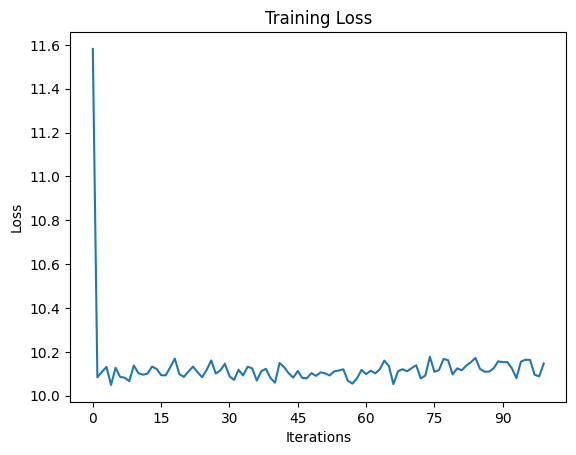

In [28]:
# plot the training loss
ax = plt.figure().gca()
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss")
ax.plot(train_losses_adam)

In [29]:
# Save the model with timestamp and dimension
tmstmp = time.strftime("%Y%m%d-%H%M%S")
torch.save(model_inception.state_dict(), "Models-pt/{}face_recognition_inception_better_pairing{}.pt".format(DIM, tmstmp))

# clean cuda memory
torch.cuda.empty_cache()

### Evaluarea modelului
Am evaluat modelul vizual prin afișarea distanțelor dintre imagini, deocamdată nu am găsit o metodă de evaluare bazată pe procente

In [30]:
def evaluate3(model, generator, device, batches):
    model.eval()
    tabel_data = "| Anchor - Positive | Anchor - Negative |\n" +\
                 "|" + 19*"-" + "+" + 19*"-" + "|"
        
    with torch.no_grad():
        for i, data in zip(tnrange(batches, desc="Batches", leave=False), generator):
            anchors, positives, negatives = data
            anchors = torch.tensor(anchors[0], device=device, dtype=torch.float32)
            positives = torch.tensor(positives[0], device=device, dtype=torch.float32)
            negatives = torch.tensor(negatives[0], device=device, dtype=torch.float32)

            anchors = torch.transpose(anchors, 1, 3)
            positives = torch.transpose(positives, 1, 3)
            negatives = torch.transpose(negatives, 1, 3)
            # print(anchors.shape, positives.shape, negatives.shape)

            anchor_embeddings = model(anchors)
            positive_embeddings = model(positives)
            negative_embeddings = model(negatives)
            distance_positive = F.pairwise_distance(anchor_embeddings, positive_embeddings)
            distance_negative = F.pairwise_distance(anchor_embeddings, negative_embeddings)

            # print the distances in a table
            if i == 0:
                print(tabel_data)
            for j in range(len(anchors)):
                tabel_data = f"| {distance_positive[j]:.15f} | {distance_negative[j]:.15f} |"
                print(tabel_data)

In [31]:
def evaluate(model, generator, device, batches, evaluattion_criterion=F.pairwise_distance):
    model.eval()
    tabel_data = "| AnchorP - Positive | AnchorN - Negative |\n" +\
                 "|" + 20*"-" + "+" + 20*"-" + "|"
        
    with torch.no_grad():
        for i, data in zip(tqdm(range(batches), desc="Batches", leave=False), generator):
            anchors_positives, positives, anchors_negatives, negatives = data
            anchors_positives = torch.tensor(anchors_positives[0], device=device, dtype=torch.float32).transpose(1, 3)
            positives = torch.tensor(positives[0], device=device, dtype=torch.float32).transpose(1, 3)
            anchors_negatives = torch.tensor(anchors_negatives[0], device=device, dtype=torch.float32).transpose(1, 3)
            negatives = torch.tensor(negatives[0], device=device, dtype=torch.float32).transpose(1, 3)

            anchor_positive_embeddings = model(anchors_positives)
            positive_embeddings = model(positives)
            anchor_negative_embeddings = model(anchors_negatives)
            negative_embeddings = model(negatives)
            similarity_positive = evaluattion_criterion(anchor_positive_embeddings, positive_embeddings)
            similarity_negative = evaluattion_criterion(anchor_negative_embeddings, negative_embeddings)

            # print the distances in a table
            if i == 0:
                print(tabel_data)
            for j in range(len(anchors_positives)):
                tabel_data = f"| {similarity_positive[j]:.16f} | {similarity_negative[j]:.16f} |"
                print(tabel_data)
            



In [32]:
generator = batch_generator3(full_dataset, pairs, 256)
model_inception = FaceRecInception().to(device)
# tmstmp="20250128-025927"
state_dict = torch.load("Models-pt/{}face_recognition_inception_better_pairing{}.pt".format(DIM, tmstmp), weights_only=True)
# Remove 'module.' prefix from keys if present
state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
model_inception.load_state_dict(state_dict=state_dict)
evaluate(model_inception, generator, device, batches=2, evaluattion_criterion=F.cosine_similarity)

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

| AnchorP - Positive | AnchorN - Negative |
|--------------------+--------------------|


| 0.8309391140937805 | 0.7792311906814575 |
| 0.0000000000000000 | -0.1644439548254013 |
| 0.9877758622169495 | 0.0817948207259178 |
| 0.9915891289710999 | -0.0973148345947266 |
| 0.8937229514122009 | 0.0000000000000000 |
| 0.8676167726516724 | 0.3379300832748413 |
| 0.9062471985816956 | -0.0973148345947266 |
| 0.7996879220008850 | 0.1066967770457268 |
| 0.9401570558547974 | 0.0000000000000000 |
| 0.0000000000000000 | 0.6691462993621826 |
| 0.9316896200180054 | 0.0000000000000000 |
| 0.9962580800056458 | 0.0000000000000000 |
| 0.6487157940864563 | 0.8803548812866211 |
| 0.9972465038299561 | 0.6360954642295837 |
| 0.9716705083847046 | 0.0000000000000000 |
| 0.0000000000000000 | 0.4322238564491272 |
| 0.4627468287944794 | 0.9981504082679749 |
| 0.8875985145568848 | 0.6528535485267639 |
| 0.1616132557392120 | 0.0323664993047714 |
| 0.8840441703796387 | 0.7485855221748352 |
| 0.8803535699844360 | 0.8618878722190857 |
| 0.3972576856613159 | 0.0000000000000000 |
| 0.8712356090545654 | 0.0000

| 0.0000000000000000 | 0.0000000000000000 |
| 0.0000000000000000 | -0.0319758057594299 |
| 0.0000000000000000 | 0.0000000000000000 |
| 0.6112023591995239 | 0.9843163490295410 |
| 0.0000000000000000 | 0.9965718388557434 |
| 0.0000000000000000 | 0.0000000000000000 |
| -0.0309984534978867 | 0.6794123053550720 |
| 0.5400955677032471 | 0.1109671518206596 |
| 0.0000000000000000 | 0.0000000000000000 |
| 0.4924210309982300 | -0.3219668865203857 |
| 0.0000000000000000 | 0.7865782380104065 |
| 0.0000000000000000 | 0.8787091970443726 |
| 0.9630357623100281 | 0.0000000000000000 |
| 0.9977007508277893 | 0.9792158603668213 |
| 0.5729738473892212 | 0.0000000000000000 |
| 0.0000000000000000 | 0.0000000000000000 |
| 0.0000000000000000 | 0.9019383192062378 |
| 0.5464965105056763 | 0.5552265644073486 |
| 0.0000000000000000 | 0.5107221603393555 |
| 0.0428348071873188 | 0.0000000000000000 |
| 0.9498995542526245 | 0.7841516733169556 |
| 0.8462126255035400 | 0.9562389254570007 |
| 0.0000000000000000 | 0.0000

##### Evaluare intuitivă a unui sample de 4 imagini. 2 matched, 2 mismatched

AnchorP - Positive Distance: 0.0
 AnchorP - Negative Distance: 0.0
  AnchorP - AnchorN Distance: 0.0 
   AnchorN - Negative Distance: 0.6456182599067688


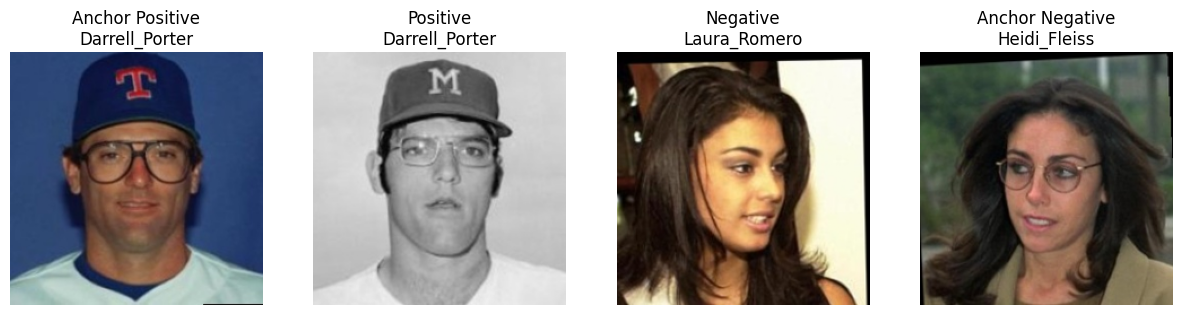

In [33]:
image_generator = batch_generator(full_dataset, pairs, 1)
an_data, pos_data, an_neg_data, neg_data = next(image_generator)
an = torch.tensor(an_data[0], device=device, dtype=torch.float32)
pos = torch.tensor(pos_data[0], device=device, dtype=torch.float32)
neg = torch.tensor(neg_data[0], device=device, dtype=torch.float32)
an_neg = torch.tensor(an_neg_data[0], device=device, dtype=torch.float32)
an_t = torch.transpose(an, 1, 3)
pos_t = torch.transpose(pos, 1, 3)
neg_t = torch.transpose(neg, 1, 3)
an_neg_t = torch.transpose(an_neg, 1, 3)
an_emb = model_inception(an_t)
pos_emb = model_inception(pos_t)
neg_emb = model_inception(neg_t)
an_neg_emb = model_inception(an_neg_t)
distance_positive = F.cosine_similarity(an_emb, pos_emb)
distance_negative = F.cosine_similarity(an_emb, neg_emb)
distance_an_neg = F.cosine_similarity(an_emb, an_neg_emb)
distance_an_neg_negatives = F.cosine_similarity(an_neg_emb, neg_emb)
print(f"AnchorP - Positive Distance: {distance_positive.item()}\n AnchorP - Negative Distance: {distance_negative.item()}\n",
      f" AnchorP - AnchorN Distance: {distance_an_neg.item()} \n   AnchorN - Negative Distance: {distance_an_neg_negatives.item()}")
fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 4, 1)
ax.imshow(an[0].cpu().numpy().transpose(0, 1, 2))
ax.axis("off")
ax.set_title(f"Anchor Positive\n{an_data[1][0]}")
ax = plt.subplot(1, 4, 2)
ax.imshow(pos[0].cpu().numpy().transpose(0, 1, 2))
ax.axis("off")
ax.set_title(f"Positive\n{pos_data[1][0]}")
ax = plt.subplot(1, 4, 3)
ax.imshow(neg[0].cpu().numpy().transpose(0, 1, 2))
ax.axis("off")
ax.set_title(f"Negative\n{neg_data[1][0]}")
ax = plt.subplot(1, 4, 4)
ax.imshow(an_neg[0].cpu().numpy().transpose(0, 1, 2))
ax.axis("off")
ax.set_title(f"Anchor Negative\n{an_neg_data[1][0]}")
plt.show()


**M-am asigurat că nu am probleme cu ponderile, crezând că ar fi 0**

In [34]:
# Check if weights are zero
for name, param in model_inception.named_parameters():
    print(f"{name} - mean: {param.mean().item()}, std: {param.std().item()}")

# Check if gradients are zero
for name, param in model_inception.named_parameters():
    if param.grad is not None:
        print(f"{name} grad - mean: {param.grad.mean().item()}, std: {param.grad.std().item()}")

conv1.weight - mean: -0.012083175592124462, std: 0.08945300430059433
conv1.bias - mean: -0.04584476351737976, std: 0.11847703158855438
inception1.0.weight - mean: -0.02820279262959957, std: 0.09581880271434784
inception1.0.bias - mean: -0.07753171026706696, std: 0.11774169653654099
inception1.2.weight - mean: -0.007573275826871395, std: 0.06715555489063263
inception1.2.bias - mean: -0.07931968569755554, std: 0.07908802479505539
inception3a1x1.0.weight - mean: 0.0028356523253023624, std: 0.08408705145120621
inception3a1x1.0.bias - mean: -0.07746152579784393, std: 0.08576899766921997
inception3a3x3.0.weight - mean: -0.0018087269272655249, std: 0.08275064080953598
inception3a3x3.0.bias - mean: -0.08226336538791656, std: 0.08885332196950912
inception3a3x3.2.weight - mean: -0.011239846237003803, std: 0.07010895758867264
inception3a3x3.2.bias - mean: -0.08388902246952057, std: 0.06095033884048462
inception3a5x5.0.weight - mean: 0.002291501499712467, std: 0.07312903553247452
inception3a5x5.0.

In [35]:
# Verify loss function
generator = batch_generator(full_dataset, pairs, 1)

# Ensure optimizer is updating parameters
for epoch in range(10):
    optimizer.zero_grad()
    anchors, positives, anchors_negatives, negatives = next(generator)
    anchors = torch.tensor(anchors[0], device=device, dtype=torch.float32).transpose(1, 3)
    positives = torch.tensor(positives[0], device=device, dtype=torch.float32).transpose(1, 3)
    negatives = torch.tensor(negatives[0], device=device, dtype=torch.float32).transpose(1, 3)
    anchors_negatives = torch.tensor(anchors_negatives[0], device=device, dtype=torch.float32).transpose(1, 3)

    
    anchor_embeddings = model_inception(anchors)
    positive_embeddings = model_inception(positives)
    negative_embeddings = model_inception(negatives)
    anchor_negative_embeddings = model_inception(anchors_negatives)
    
    loss_fn = AMSoftmaxLoss()
    loss = loss_fn(anchor_embeddings, positive_embeddings, negative_embeddings, anchor_negative_embeddings)
    loss.backward()
    optimizer.step()
    
    print(f"Loss: {loss.item()}")
    for name, param in model_inception.named_parameters():
        if param.grad is not None:
            print(f"{name} grad - mean: {param.grad.mean().item()}, std: {param.grad.std().item()}")

Loss: 13.905342102050781
conv1.weight grad - mean: 0.008185677230358124, std: 0.021179519593715668
conv1.bias grad - mean: 0.017636297270655632, std: 0.05254720523953438
inception1.0.weight grad - mean: 0.019817525520920753, std: 0.14265364408493042
inception1.0.bias grad - mean: 0.011911632493138313, std: 0.05733104050159454
inception1.2.weight grad - mean: 0.0014386017573997378, std: 0.022918982431292534
inception1.2.bias grad - mean: 0.0017350515117868781, std: 0.006117647513747215
inception3a1x1.0.weight grad - mean: 0.000602100626565516, std: 0.005098217632621527
inception3a1x1.0.bias grad - mean: 0.0002509872429072857, std: 0.0004851395497098565
inception3a3x3.0.weight grad - mean: 0.004421641584485769, std: 0.0506693534553051
inception3a3x3.0.bias grad - mean: 0.0016835586866363883, std: 0.005638834089040756
inception3a3x3.2.weight grad - mean: 0.00010932379518635571, std: 0.006225843448191881
inception3a3x3.2.bias grad - mean: 0.00011234239354962483, std: 0.000353041134076193
i

Loss: 5.596587181091309
conv1.weight grad - mean: 0.008185677230358124, std: 0.021179519593715668
conv1.bias grad - mean: 0.017636297270655632, std: 0.05254720523953438
inception1.0.weight grad - mean: 0.019817525520920753, std: 0.14265364408493042
inception1.0.bias grad - mean: 0.011911632493138313, std: 0.05733104050159454
inception1.2.weight grad - mean: 0.0014386017573997378, std: 0.022918982431292534
inception1.2.bias grad - mean: 0.0017350515117868781, std: 0.006117647513747215
inception3a1x1.0.weight grad - mean: 0.000602100626565516, std: 0.005098217632621527
inception3a1x1.0.bias grad - mean: 0.0002509872429072857, std: 0.0004851395497098565
inception3a3x3.0.weight grad - mean: 0.004421641584485769, std: 0.0506693534553051
inception3a3x3.0.bias grad - mean: 0.0016835586866363883, std: 0.005638834089040756
inception3a3x3.2.weight grad - mean: 0.00010932379518635571, std: 0.006225843448191881
inception3a3x3.2.bias grad - mean: 0.00011234239354962483, std: 0.000353041134076193
in

Loss: 19.080909729003906
conv1.weight grad - mean: -0.03187739476561546, std: 0.06255604326725006
conv1.bias grad - mean: -0.1167750209569931, std: 0.23589324951171875
inception1.0.weight grad - mean: -0.07247597724199295, std: 0.5137298107147217
inception1.0.bias grad - mean: -0.0670783594250679, std: 0.25089195370674133
inception1.2.weight grad - mean: -0.008392015472054482, std: 0.07926103472709656
inception1.2.bias grad - mean: -0.008246376179158688, std: 0.025932522490620613
inception3a1x1.0.weight grad - mean: -0.0007309289067052305, std: 0.011222099885344505
inception3a1x1.0.bias grad - mean: -0.0006755274953320622, std: 0.001378268119879067
inception3a3x3.0.weight grad - mean: -0.013723377138376236, std: 0.17667622864246368
inception3a3x3.0.bias grad - mean: -0.007015963550657034, std: 0.0200980082154274
inception3a3x3.2.weight grad - mean: -0.0011495088692754507, std: 0.02882460691034794
inception3a3x3.2.bias grad - mean: -0.00027104976470582187, std: 0.0008124061278067529
inc

Loss: 1.5771985054016113
conv1.weight grad - mean: -0.04693204537034035, std: 0.11566948890686035
conv1.bias grad - mean: -0.1428702175617218, std: 0.3469744622707367
inception1.0.weight grad - mean: -0.11655695736408234, std: 0.8835017681121826
inception1.0.bias grad - mean: -0.08669807761907578, std: 0.4002012014389038
inception1.2.weight grad - mean: -0.012741195037961006, std: 0.12182556837797165
inception1.2.bias grad - mean: -0.012669957242906094, std: 0.04291382059454918
inception3a1x1.0.weight grad - mean: -0.004836296662688255, std: 0.038465049117803574
inception3a1x1.0.bias grad - mean: -0.0021918872371315956, std: 0.004255658946931362
inception3a3x3.0.weight grad - mean: -0.026263680309057236, std: 0.3183667063713074
inception3a3x3.0.bias grad - mean: -0.011109618470072746, std: 0.03848286718130112
inception3a3x3.2.weight grad - mean: -0.002161826007068157, std: 0.030888190492987633
inception3a3x3.2.bias grad - mean: -0.0007052187575027347, std: 0.0021606485825031996
incepti

Loss: 14.958884239196777
conv1.weight grad - mean: -0.03839005529880524, std: 0.10081234574317932
conv1.bias grad - mean: -0.1253954917192459, std: 0.2855759561061859
inception1.0.weight grad - mean: -0.09488864243030548, std: 0.747528612613678
inception1.0.bias grad - mean: -0.07445111125707626, std: 0.3321409821510315
inception1.2.weight grad - mean: -0.011025798507034779, std: 0.10826889425516129
inception1.2.bias grad - mean: -0.01043742150068283, std: 0.035845909267663956
inception3a1x1.0.weight grad - mean: -0.004734077025204897, std: 0.03646097332239151
inception3a1x1.0.bias grad - mean: -0.001978636719286442, std: 0.0038206945173442364
inception3a3x3.0.weight grad - mean: -0.0220380499958992, std: 0.2725714445114136
inception3a3x3.0.bias grad - mean: -0.008996529504656792, std: 0.03186539188027382
inception3a3x3.2.weight grad - mean: -0.0018166080117225647, std: 0.024079425260424614
inception3a3x3.2.bias grad - mean: -0.0005640189629048109, std: 0.0017132291104644537
inception3

Loss: 14.62829303741455
conv1.weight grad - mean: -0.04405359551310539, std: 0.1106790155172348
conv1.bias grad - mean: -0.13631552457809448, std: 0.3175518214702606
inception1.0.weight grad - mean: -0.10941515862941742, std: 0.8461194634437561
inception1.0.bias grad - mean: -0.0823059231042862, std: 0.36603283882141113
inception1.2.weight grad - mean: -0.012345660477876663, std: 0.1183243915438652
inception1.2.bias grad - mean: -0.011459017172455788, std: 0.03897159919142723
inception3a1x1.0.weight grad - mean: -0.004920778796076775, std: 0.038023442029953
inception3a1x1.0.bias grad - mean: -0.002061992883682251, std: 0.0039914012886583805
inception3a3x3.0.weight grad - mean: -0.024685410782694817, std: 0.30315762758255005
inception3a3x3.0.bias grad - mean: -0.010111862793564796, std: 0.035179782658815384
inception3a3x3.2.weight grad - mean: -0.0020883132237941027, std: 0.026680944487452507
inception3a3x3.2.bias grad - mean: -0.0006250619189813733, std: 0.0019138343632221222
inception

### Folosirea librăriei [FiftyOne](https://voxel51.com/)
**Încarc un dataset de testare compus din 100 imagini**

In [36]:
# random_samples = fo.Dataset.from_dir(
#     dataset_dir='/home/ichitu/fiftyone/lfw/lfw_funneled',
#     dataset_type=fo.types.dataset_types.ImageClassificationDirectoryTree,
#     name='lfw_funneled_random',
#     overwrite=True,
#     # max_samples=50
    
# )
random_samples = foz.load_zoo_dataset(
    "lfw",
    split="test",
)
random_dataset = LFWDataset(random_samples)

Split 'test' already downloaded


Loading 'lfw' split 'test'


   0% ||--------------|    1/3708 [9.7ms elapsed, 35.9s remaining, 103.1 samples/s] 

  16% |██/------------|  585/3708 [142.7ms elapsed, 762.0ms remaining, 4.1K samples/s] 

  40% |█████----------| 1471/3708 [338.7ms elapsed, 515.0ms remaining, 4.3K samples/s] 

  64% |█████████\-----| 2375/3708 [533.1ms elapsed, 299.2ms remaining, 4.5K samples/s] 

  89% |█████████████|-| 3305/3708 [901.1ms elapsed, 109.9ms remaining, 3.7K samples/s] 

 100% |███████████████| 3708/3708 [989.0ms elapsed, 0s remaining, 3.7K samples/s]      


Dataset 'lfw-test' created


* Preprocesarea și alcătuirea unei liste cu imaginile mele

In [37]:
def preprocess_image(image):
    image = image.resize((224, 224))
    image = transforms.ToTensor()(image)
    # image = F.normalize(image)
    image = image.unsqueeze(0)
    return image

def get_image(image):
    return Image.fromarray(image)

def get_images(images):
    return [get_image(image) for image in images]

def get_image_from_sample(sample):
    return get_image(np.array(sample[0]))

def get_images_from_samples(samples):
    return [get_image_from_sample(sample) for sample in samples]

print(len(random_dataset))
images = get_images_from_samples(random_dataset)
print(len(images))

3708


3708


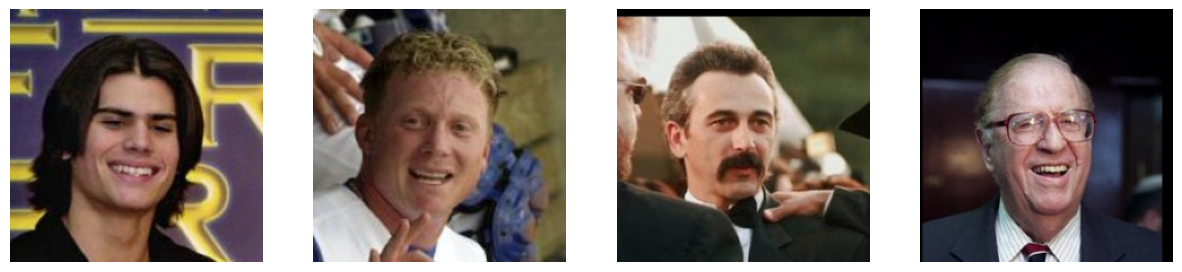

In [38]:
plt.figure(figsize=(15, 15))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[i])
    plt.axis("off")

* Creearea unei liste de embeddinguri pentru imagini

In [39]:
def get_embedding(image):
    image = preprocess_image(image)
    # print(image.shape)
    # plt.imshow(image[0])
    # get image on cuda
    image = image.cuda()
    # get embedding
    embedding = model_inception(image)
    return embedding.cpu().detach().numpy()

def get_embeddings(images):
    embeddings = []
    for image in tqdm(images):
       embeddings.append(get_embedding(image))
    return np.array(embeddings)

In [40]:
embeddings = get_embeddings(images)
embeddings = embeddings.reshape(embeddings.shape[0], embeddings.shape[2])
print(embeddings.shape)

  0%|          | 0/3708 [00:00<?, ?it/s]

(3708, 128)


### Testare acuratețe

In [41]:
from sklearn.metrics import accuracy_score


# print(pairs[0]['matched'])
# print(pairs[0]['mismatched'])

def get_image_from_path(path):
    return Image.open(path)

def get_images_from_pairs(pair, dataset_path='/home/ichitu/fiftyone/lfw/lfw_funneled'):
    matched = pair['matched']
    mismatched = pair['mismatched']
    matched_images = []
    mismatched_images = []
    for match in matched:
        matched_images.append((get_image_from_path(match[0]), get_image_from_path(match[1])))
    for mismatch in mismatched:
        mismatched_images.append((get_image_from_path(mismatch[0]), get_image_from_path(mismatch[1])))
    return matched_images, mismatched_images


def verify(embedding1, embedding2, threshold=0.35):
    embedding1 = torch.tensor(embedding1, device=device, dtype=torch.float32)
    embedding2 = torch.tensor(embedding2, device=device, dtype=torch.float32)
    # print(embedding1.shape, embedding2.shape)
    similarity = F.cosine_similarity(embedding1, embedding2)
    # print(similarity)
    return abs(similarity.item() - 1.0) < threshold
    


predictions = []

# for i in range(0, len(pairs), 2):
#     matched, mismatched = get_images_from_pairs(pairs[i])
#     matched_embeddings1, matched_embeddings2 = [], []
#     for match in matched:
#         matched_embeddings1.append(get_embedding(match[0]))
#         matched_embeddings2.append(get_embedding(match[1]))
#     mismatched_embeddings1, mismatched_embeddings2 = [], []
#     for mismatch in mismatched:
#         mismatched_embeddings1.append(get_embedding(mismatch[0]))
#         mismatched_embeddings2.append(get_embedding(mismatch[1]))
#     for i in range(len(matched_embeddings1)):
#         predictions.append(verify(matched_embeddings1[i], matched_embeddings2[i]))
#     for i in range(len(mismatched_embeddings1)):
#         predictions.append(verify(mismatched_embeddings1[i], mismatched_embeddings2[i]))

for i in tnrange(0, len(pairs)):
    matched, mismatched = get_images_from_pairs(pairs[i])
    matched_embeddings1, matched_embeddings2 = [], []
    for j, match in zip(tnrange(len(matched), desc="Matched", leave=False), matched):
        matched_embeddings1.append(get_embedding(match[0]))
        matched_embeddings2.append(get_embedding(match[1]))
        predictions.append(verify(matched_embeddings1[j], matched_embeddings2[j]))
    mismatched_embeddings1, mismatched_embeddings2 = [], []
    for j, mismatch in zip(tnrange(len(mismatched), desc="Mismatched", leave=False), mismatched):
        mismatched_embeddings1.append(get_embedding(mismatch[0]))
        mismatched_embeddings2.append(get_embedding(mismatch[1]))
        predictions.append(verify(mismatched_embeddings1[j], mismatched_embeddings2[j]))
    for j in tnrange(len(matched), desc="Matched verify", leave=False):
        predictions.append(verify(matched_embeddings1[j], matched_embeddings2[j]))
    for j in tnrange(len(mismatched), desc="Mismatched verify", leave=False):
        predictions.append(verify(mismatched_embeddings1[j], mismatched_embeddings2[j]) == 0)


  0%|          | 0/10 [00:00<?, ?it/s]

Matched:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched:   0%|          | 0/300 [00:00<?, ?it/s]

Matched verify:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched verify:   0%|          | 0/300 [00:00<?, ?it/s]

Matched:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched:   0%|          | 0/300 [00:00<?, ?it/s]

Matched verify:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched verify:   0%|          | 0/300 [00:00<?, ?it/s]

Matched:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched:   0%|          | 0/300 [00:00<?, ?it/s]

Matched verify:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched verify:   0%|          | 0/300 [00:00<?, ?it/s]

Matched:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched:   0%|          | 0/300 [00:00<?, ?it/s]

Matched verify:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched verify:   0%|          | 0/300 [00:00<?, ?it/s]

Matched:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched:   0%|          | 0/300 [00:00<?, ?it/s]

Matched verify:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched verify:   0%|          | 0/300 [00:00<?, ?it/s]

Matched:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched:   0%|          | 0/300 [00:00<?, ?it/s]

Matched verify:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched verify:   0%|          | 0/300 [00:00<?, ?it/s]

Matched:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched:   0%|          | 0/300 [00:00<?, ?it/s]

Matched verify:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched verify:   0%|          | 0/300 [00:00<?, ?it/s]

Matched:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched:   0%|          | 0/300 [00:00<?, ?it/s]

Matched verify:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched verify:   0%|          | 0/300 [00:00<?, ?it/s]

Matched:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched:   0%|          | 0/300 [00:00<?, ?it/s]

Matched verify:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched verify:   0%|          | 0/300 [00:00<?, ?it/s]

Matched:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched:   0%|          | 0/300 [00:00<?, ?it/s]

Matched verify:   0%|          | 0/300 [00:00<?, ?it/s]

Mismatched verify:   0%|          | 0/300 [00:00<?, ?it/s]

In [42]:
real = []
for i in range(0, len(pairs)):
    real.extend([True]*2*len(pairs[i]['matched']))
    real.extend([False]*2*len(pairs[i]['mismatched']))

print(len(real))
for i in range(0, len(real)):
    print(real[i], end=" ")
    if (i+1) % 600 == 0:
        print(f"\n{predictions[i-599:i+1]}")
        print("\n300", end="\n")

12000
True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True True

In [43]:
score = accuracy_score(predictions, real)
print(f"Accuracy: {score*100}% for {len(predictions)} samples")

Accuracy: 43.65% for 12000 samples


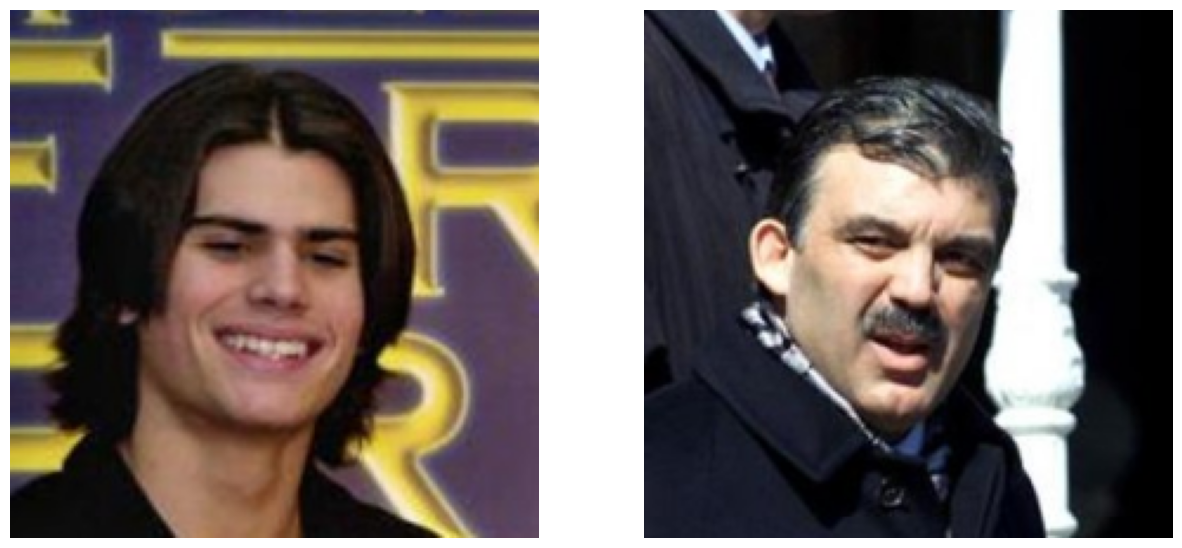

(1, 128) (1, 128)


tensor([[-0.0037, -0.0243, -0.1634,  0.0214, -0.0205, -0.0100,  0.0441, -0.0103,
         -0.0246,  0.0054, -0.1632, -0.0562, -0.1074,  0.0106,  0.0734, -0.0037,
          0.0285, -0.0071, -0.0100,  0.0276,  0.0855,  0.0007, -0.1275,  0.1629,
          0.1582,  0.0192, -0.0742, -0.1255,  0.0092, -0.0761, -0.0558,  0.0139,
         -0.0074, -0.1585, -0.1515, -0.1479, -0.1484,  0.0269,  0.0757, -0.0066,
          0.0005, -0.0864,  0.1508,  0.1208, -0.1488,  0.0870,  0.0143,  0.1342,
         -0.1180,  0.0146, -0.0659,  0.1487,  0.0098, -0.0165,  0.0278, -0.0396,
         -0.1568, -0.1378, -0.1337,  0.1329,  0.0004,  0.0023,  0.0237, -0.1391,
         -0.1209, -0.0260, -0.0250, -0.0293,  0.0219, -0.0198,  0.1434, -0.1519,
          0.0457,  0.0164,  0.0856, -0.0223,  0.0740,  0.0217, -0.1501, -0.0226,
         -0.1282, -0.1283,  0.0072, -0.1277, -0.0373,  0.0287, -0.0195, -0.1283,
          0.1511, -0.0221, -0.0215,  0.1019,  0.0518,  0.0040, -0.0262,  0.0252,
          0.1458, -0.0050,  

In [44]:
# try to get embeddings for two images, i give the path to the images
def get_embeddings(image1, image2):
    # plot the images
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 2, 1)
    plt.imshow(image1)
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(image2)
    plt.axis("off")
    plt.show()
    embedding1 = get_embedding(image1)
    embedding2 = get_embedding(image2)
    return embedding1, embedding2

# get the embeddings for two images
embedding1, embedding2 = get_embeddings(images[0], images[23])
print(embedding1.shape, embedding2.shape)

def verify(embedding1, embedding2, threshold=0.1):
    embedding1 = torch.tensor(embedding1, device=device, dtype=torch.float32)
    embedding2 = torch.tensor(embedding2, device=device, dtype=torch.float32)
    print(embedding1)
    print(embedding2)
    similarity = F.cosine_similarity(embedding1, embedding2)
    print(similarity)
    return abs(similarity.item() - 1.0) < threshold

# see if the embeddings are similar
print("Similar" if verify(embedding1, embedding2) else "Not Similar")

* Folosirea [FiftyOne Brain](https://docs.voxel51.com/brain.html) pentru a avea o reprezentare în spațiu 2D a embeddingurilor

In [45]:
results = fob.compute_visualization(
    random_samples,
    embeddings=embeddings,
    label_field="ground_truth.label",
    classes=random_samples.values("ground_truth.label"),
    brain_key="faceNet_embeddings_tsne",
    output_dir="faceNet_embeddings",
    overwrite=True,
    method = "tsne",
    
)

results = fob.compute_visualization(
    random_samples,
    embeddings=embeddings,
    label_field="ground_truth.label",
    classes=random_samples.values("ground_truth.label"),
    brain_key="faceNet_embeddings_pca",
    output_dir="faceNet_embeddings",
    overwrite=True,
    method = "pca",
    
)

results = fob.compute_visualization(
    random_samples,
    embeddings=embeddings,
    label_field="ground_truth.label",
    classes=random_samples.values("ground_truth.label"),
    brain_key="faceNet_embeddings_umap",
    output_dir="faceNet_embeddings",
    overwrite=True,
    method = "umap",
    
)

Generating visualization...


/home/ichitu/machine-learning/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3708 samples in 0.000s...
[t-SNE] Computed neighbors for 3708 samples in 0.087s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3708
[t-SNE] Computed conditional probabilities for sample 2000 / 3708
[t-SNE] Computed conditional probabilities for sample 3000 / 3708
[t-SNE] Computed conditional probabilities for sample 3708 / 3708
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.089s


[t-SNE] Iteration 50: error = 57.7186012, gradient norm = 0.0282198 (50 iterations in 0.176s)
[t-SNE] Iteration 100: error = 50.2139740, gradient norm = 0.0148362 (50 iterations in 0.150s)


[t-SNE] Iteration 150: error = 47.6951752, gradient norm = 0.0094210 (50 iterations in 0.150s)
[t-SNE] Iteration 200: error = 46.3961411, gradient norm = 0.0078500 (50 iterations in 0.148s)


[t-SNE] Iteration 250: error = 45.5999298, gradient norm = 0.0057734 (50 iterations in 0.147s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.599930
[t-SNE] Iteration 300: error = 0.3342350, gradient norm = 0.0103101 (50 iterations in 0.147s)


[t-SNE] Iteration 350: error = -0.0541033, gradient norm = 0.0099401 (50 iterations in 0.163s)
[t-SNE] Iteration 400: error = -0.2486751, gradient norm = 0.0092187 (50 iterations in 0.200s)


[t-SNE] Iteration 450: error = -0.3657639, gradient norm = 0.0085928 (50 iterations in 0.178s)
[t-SNE] Iteration 500: error = -0.4464422, gradient norm = 0.0081118 (50 iterations in 0.146s)


[t-SNE] Iteration 550: error = -0.5063551, gradient norm = 0.0075184 (50 iterations in 0.146s)
[t-SNE] Iteration 600: error = -0.5518180, gradient norm = 0.0068383 (50 iterations in 0.146s)


[t-SNE] Iteration 650: error = -0.5891479, gradient norm = 0.0064449 (50 iterations in 0.146s)
[t-SNE] Iteration 700: error = -0.6224153, gradient norm = 0.0063687 (50 iterations in 0.145s)


[t-SNE] Iteration 750: error = -0.6531876, gradient norm = 0.0063428 (50 iterations in 0.186s)
[t-SNE] Iteration 800: error = -0.6819619, gradient norm = 0.0063144 (50 iterations in 0.143s)


[t-SNE] Iteration 850: error = -0.7095398, gradient norm = 0.0064032 (50 iterations in 0.144s)
[t-SNE] Iteration 900: error = -0.7359505, gradient norm = 0.0064757 (50 iterations in 0.143s)


[t-SNE] Iteration 950: error = -0.7621269, gradient norm = 0.0066799 (50 iterations in 0.139s)
[t-SNE] Iteration 1000: error = -0.7869709, gradient norm = 0.0068083 (50 iterations in 0.141s)
[t-SNE] KL divergence after 1000 iterations: -0.786971
Generating visualization...


Generating visualization...


/home/ichitu/machine-learning/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP( verbose=True)
Tue Feb  4 04:07:04 2025 Construct fuzzy simplicial set


Tue Feb  4 04:07:09 2025 Finding Nearest Neighbors


Tue Feb  4 04:07:12 2025 Finished Nearest Neighbor Search


Tue Feb  4 04:07:14 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs


	completed  50  /  500 epochs


	completed  100  /  500 epochs


	completed  150  /  500 epochs


	completed  200  /  500 epochs


	completed  250  /  500 epochs


	completed  300  /  500 epochs


	completed  350  /  500 epochs


	completed  400  /  500 epochs


	completed  450  /  500 epochs


Tue Feb  4 04:07:20 2025 Finished embedding


**Metode de calculare**
* TSNE
* PCA
* UMAP

Din ce am observat, PCA pare o reprezentare mai potrivită

In [46]:

sess = fo.launch_app(dataset=random_samples, port=10100)
sess.open_tab()

<IPython.core.display.Javascript object>